## Masterthesis Project

Import of Packages

In [167]:
# Import of Packages
import numpy as np
import time

# Importing the Functions File
import Functions as fn

# Import of Packages for Functions
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools
import itertools

# Import of Packages for Optimization
import scipy.optimize as opt

# Start of Timer to Measure Runtime
start_time = time.time()

Log Parameter

In [168]:
# mu = -2.23
# sigma = 0.2  # Adjust this to your actual sigma value

# # Compute the expected mean of lognormal distribution
# lognormal_mean = np.exp(mu + (sigma**2) / 2)
# print(f"Expected mean for mu={mu}, sigma={sigma}: {lognormal_mean}")


# # Function to find mu for a target mean
# def find_mu_for_mean(target_mean, sigma):
#     return np.log(target_mean) - (sigma**2) / 2


# # Compute the correct mu for a desired mean of 0.01
# target_mean = 0.1
# correct_mu = find_mu_for_mean(target_mean, sigma)

# print(f"To get a mean of {target_mean}, set mu={correct_mu:.4f} for sigma={sigma}")

Shock

In [169]:
# # Which One to Use?
# # Shock length
# Exponential if shocks decay quickly over time.
# duration = np.random.exponential(scale=2.5)  # Mean duration ~2.5 years
# # Normal if most drops cluster around an average.
# duration2 = np.random.normal(loc=2.5, scale=1.0)
# duration2 = max(duration2, 0.5)  # Ensure no negative duration
# # Log-Normal if occasional long recoveries exist.
# duration3 = np.random.lognormal(mean=0.8, sigma=0.4)

# # Shock Size
# # Exponential
# delta_demand1 = -np.random.exponential(scale=10)  # Mean drop ~10%
# # Normal
# delta_demand2 = np.random.normal(loc=-20, scale=5)  # Drop in percentage
# # Log-Normal
# delta_demand3 = -np.random.lognormal(mean=2.5, sigma=0.5)  # Always negativ


# # For Random Seed Use
# np.random.seed(np.random.randint(0, 2**16))

## Parameters

In [170]:
Param = {
    "seed": 1,  # Np Random Seed Parameter
    "Dt0": 25000000,  # Demand at t0
    "dt": 1,  # Steptime in Years
    "Fth": 20,  # Time Horizon of Forecasts in Steptime
    "No_Forecasts": 10,  # Number of Forecasts
    "No_Forecasts_plot": 100,  # Number of Forecasts to be plotted
    "mu": 0.042754330256447565,  # Average Demand growth per year
    "sigma": 0.05813761525452841,  # Volatility of Demand development per year
    "lambda": 0.003,  # Average number of shocks per year
    "shock_scale": 1.5,  # Scale of the Shocks
    "recovery_scale": 1.5,  # Scale of the Recovery
    "recovery_sigma": 0.4,  # Volatility of Recovery
    "shock_drop_scale": 15,  # Scale of the Shock Drop in Percent of Dt0
    "recovery_steepness": 0.1,  # Steepness of the Recovery
    "S_curve_offset": 20,  # Offset for S-Curve in Percent
    "p_down": 0.1,  # Probability of a step in the S-Curve being negative
    "scale_down": 0.5,  # Scale for downward steps on S-Curve
    "L": 1,  # S-Curve Parameter (Saturation now set to 100% as max)
    "k": 0.3,  # S-Curve Parameter (steepness)
    "t0_factor": 0.6,  # S-Curve Parameter t0 (Settle Point)
    "smoothing_factor_demand": 0.1,  # Smoothing Factor for the Demand Scenario Trend
    "smoothing_factor_Load_Factor": 1,  # Smoothing Factor for the Load Factor Trend
    "adjusted_mu": 0.003,  # Adjusted mu for the Load Factor
    "LF": 0.8,  # Initial Load Factor
    "K0": 90,  # Initial Capacity of Jet A1 aircraft stands
    "K0_LH": 0,  # Initial Capacity of LH2 aircraft stands
    "condition": 0,  # Condition for over, under capacity cases
    "p_Dock": 0.5,  # Share of ATMs handled at Dockstands
    "alpha": 0.8,  # Economie of Scale Parameter
    "CC_Dock_Jet": 50000,  # Construction cost of Jet A1 aircraft dock stands per unit of K
    "CC_Open_Jet": 30000,  # Construction cost of Jet A1 aircraft open stands per unit of K
    "CC_Dock_LH2": 80000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Open_LH2": 50000,  # Construction cost of LH2 aircraft dock stands per unit of K
    "CC_Truck_LH2": 2500,  # Acquisition cost of refueling trucks per unit of K
    "CC_Pipeline_LH2": 30000,  # Construction cost of LH2 pipelines per unit of K
    "TS_LH": 100000,  # Threshold for LH2 demand before pipeline installation viable
    "LH_Fuel_ATM": 20,  # LH2 Demand per LH2 Aircraft Movement
    "CE_Dock_Jet": 150,  # Cost of energy and water for Jet A1 dockstands per unit of K used
    "CE_Open_Jet": 50,  # Cost of energy and water for Jet A1 openstands per unit of K used
    "CM_Over_Jet": 50,  # Cost of over (unused) Jet A1 stand capacity per unit of K unused
    "CM_Under_Jet": 50,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Dock_LH": 200,  # Cost of energy and water for LH2 dockstands per unit of K
    "CE_Open_LH": 100,  # Cost of energy and water for LH2 openstands per unit of K
    "CM_Over_LH": 50,  # Cost of over (unused) LH2 stand capacity per unit of K unused
    "CM_Under_LH": 50,  # Opportunity cost of lacking Jet A1 stand capacity per unit of K missing
    "CE_Terminal": 30,  # Cost of terminal operations in USD per unit of passenger
    "re_Dock_Jet": 100,  # Revenue per Jet A1 ATM at dockstands per unit of ATM
    "re_Open_Jet": 80,  # Revenue per Jet A1 ATM at openstands per unit of ATM
    "rf_Jet": 50,  # Revenue from Jet A1 fuel sales per unit of ATM
    "re_Dock_LH": 200,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "re_Open_LH": 100,  # Revenue per LH2 ATM at dockstands per unit of ATM
    "rf_LH": 100,  # Revenue from LH2 fuel sales per unit of ATM
    "re_Pax": 35,  # Revenue per passenger within the terminal per unit of passenger
    "re_Rent": 0,  # Revenue from renting spaces per unit of capacity K
    "discount_rate": 0.9,  # Discount rate for NPV calculation
    "Initial_Investment": 200000000,  # Initial investment cost
    "allowed_values": np.array([0, 1, 2, 3, 4]),  # Capacity Increase Limit
    "population": 1000,  # Number of population mutations in the genetic algorithm
}

# Add time vectors and matrices to Param
Param["time"] = np.arange(1, Param["Fth"] + 2, Param["dt"])

# Number of shocks per Forecast (No_Forecasts)
Param["num_shocks"] = Param["No_Forecasts"] * 0.5

# Mix and Capacity of the Aircraft Types
Param["Mix"] = np.array([0.60, 0.25, 0.15])  # Short, Medium, Longhaul Mix
Param["Pax_capacity"] = np.array([80, 180, 230])  # Short, Medium, Longhaul Capacity
Param["deltas"] = np.array([-0.0, +0.000, +0.0])  # Change per time step

# Design Hour Load Limits according to the Infra Slides in Millions of Pax
Param["DHL_Limits"] = np.array([0.0, 1, 10, 20])

# Design Hour Load Factors according to the Infra Slides in Percent
Param["DHL_Factors"] = np.array([0.05, 0.04, 0.035, 0.03])

# Turnaournd Factors for Mix
Param["TTF"] = np.array([1, 1, 1])

## Passenger Demand

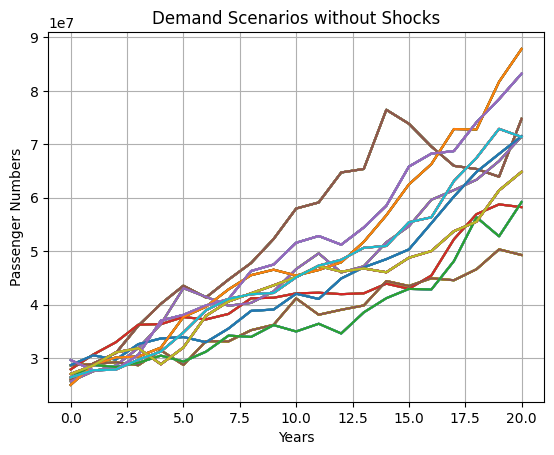

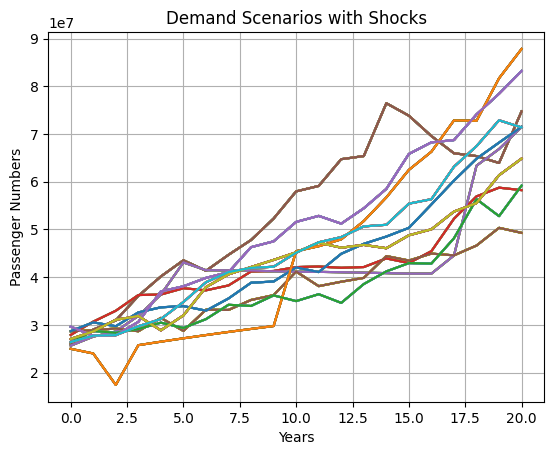

In [171]:
Forecast = fn.Generate_scenarios(Param)
fn.Scenario_plot(Param, Forecast, True, "Demand Scenarios without Shocks")

Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, False)
fn.Scenario_plot(Param, Shock_Scenarios, True, "Demand Scenarios with Shocks")

# # To see number of Shocks
# Shock_Scenarios = fn.Shock_generation(Param, Forecast, None, True)
# fn.Scenario_plot(Param, Shock_Scenarios[0], True, "Demand Scenarios with Shocks")
# print("Shocks generated", Shock_Scenarios[1])

## Design Hour Load

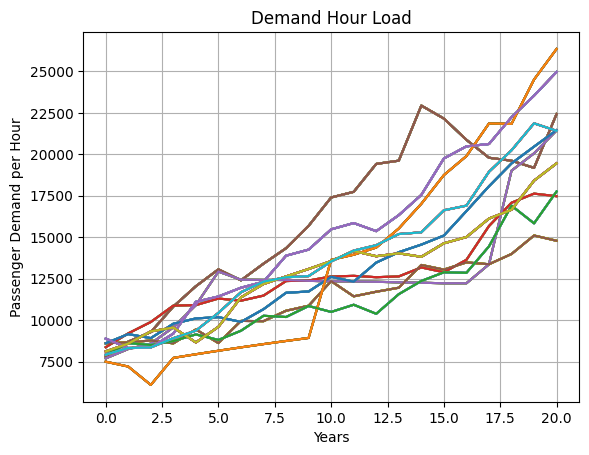

In [172]:
DHL = fn.DHL_Calculation(Param, Shock_Scenarios)
fn.Scenario_plot(Param, DHL, True, "Demand Hour Load", "Passenger Demand per Hour")

## Load Factor

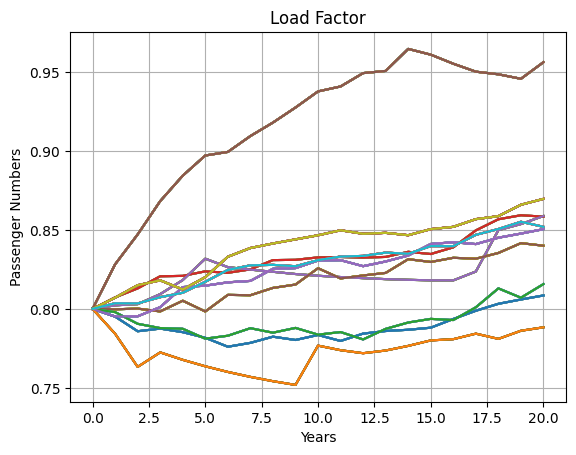

In [173]:
Load_Factor_matrix = fn.Load_Factor_matrix(Param, DHL)
fn.Scenario_plot(Param, Load_Factor_matrix, True, "Load Factor")

## Air Traffic Movements

In [174]:
ATM_matrix = fn.ATM(Param, DHL, Load_Factor_matrix)

Plotting the ATM

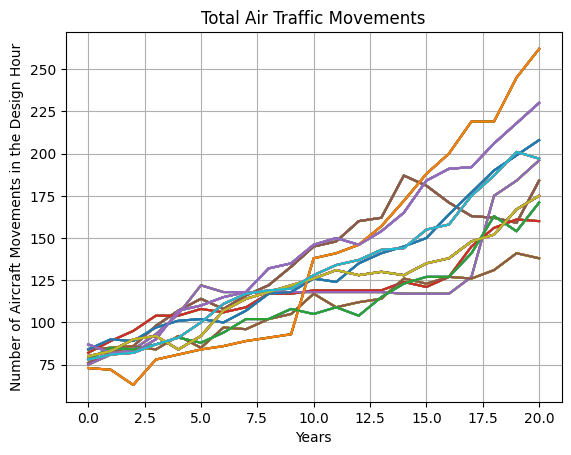

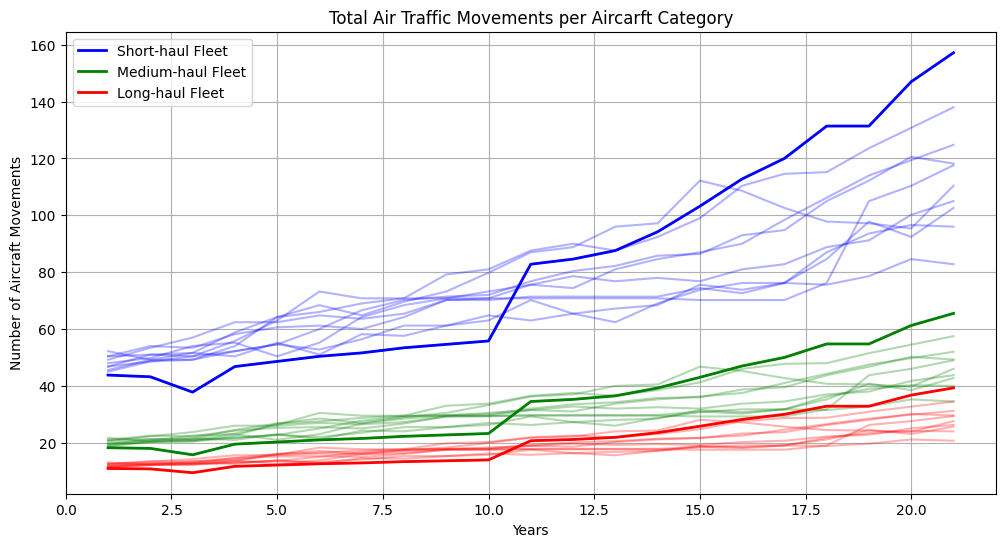

In [175]:
fn.Scenario_plot(
    Param,
    ATM_matrix[0],
    True,
    "Total Air Traffic Movements",
    "Number of Aircraft Movements in the Design Hour",
)


fn.ATM_plot(ATM_matrix[1], Param)
# fn.Scenario_plot(
#     Param,
#     ATM_test_matrix[1],
#     True,
#     "Total Air Traffic Movements per Aircarft Category",
#     "Number of Aircraft Movements",
# )

## S-Curve

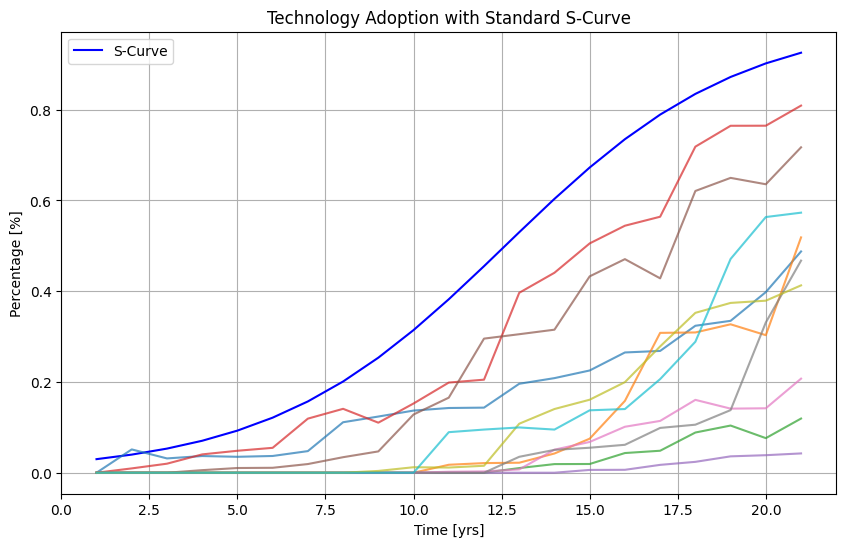

In [176]:
S_value_matrix = fn.S_curve(Param)
fn.S_curve_plot(
    Param,
    S_value_matrix,
)

# fn.Scenario_plot(
#     Param,
#     S_values,
#     NoStep=True,
#     Title="Technology Adoption without Standard S-Curve",
#     label="Percentage [%]",
# )

## Hydrogen Adoption

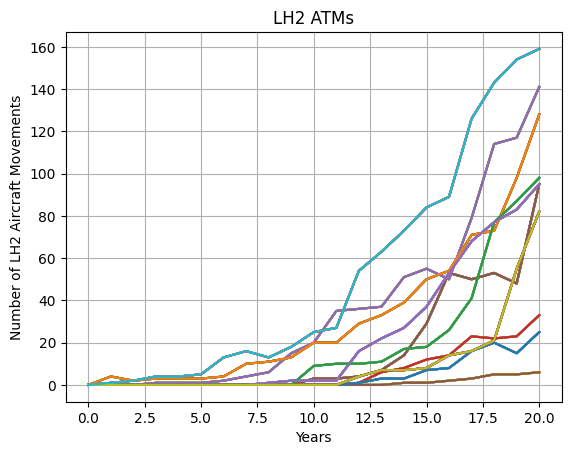

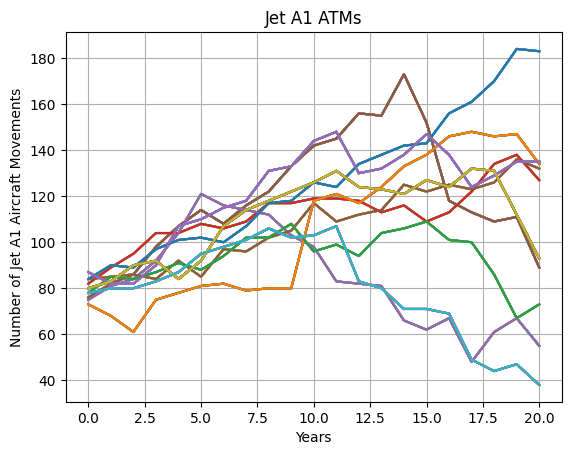

In [177]:
ATM_LH_adoption = fn.LH2_technology_adoption(Param, S_value_matrix, ATM_matrix)

ATM_LH = ATM_LH_adoption[0]
fn.Scenario_plot(Param, ATM_LH, True, "LH2 ATMs", "Number of LH2 Aircraft Movements")
# fn.ATM_plot(LH2[1], Param)

ATM_Jet = ATM_matrix[0] - ATM_LH
fn.Scenario_plot(
    Param, ATM_Jet, True, "Jet A1 ATMs", "Number of Jet A1 Aircraft Movements"
)

ATM_Jet_mix = np.round(ATM_matrix[1] - ATM_LH_adoption[1], 0)
ATM_LH_mix = ATM_LH_adoption[1]
# fn.ATM_plot(ATM_Jet_mix, Param)
# fn.ATM_plot(ATM_LH_mix, Param)
ATM_mix = ATM_Jet_mix + ATM_LH_mix
# fn.ATM_plot(
#     ATM_total_mix,
#     Param,
# )

# Complete Scenarios

In [178]:
# Passenger Demand Scenario
print(Shock_Scenarios.shape)
# print("First Demand Scneario: \n", Shock_Scenarios[0])

# Air Traffic Mix Scenario
print(ATM_matrix[0].shape)
# print("First ATM Scneario: \n", ATM_test_matrix[0])

# Technology Adoption Scenario
print(S_value_matrix.shape)
# print("First S-Curve Scneario: \n", S_values[0])

(10, 21)
(10, 21)
(10, 21)


ATM Mix

# Optimization Alorithm

In [179]:
GA_dual = fn.GA_dual(Param, ATM_mix, S_value_matrix, Shock_Scenarios)
delta_K_GA = GA_dual[0] + GA_dual[1]

In [180]:
NPV_GA = fn.NPV_calculation(
    Param,
    delta_K_GA,
    GA_dual[0],
    GA_dual[1],
    ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

# print(NPV_GA)

Visulization Jet

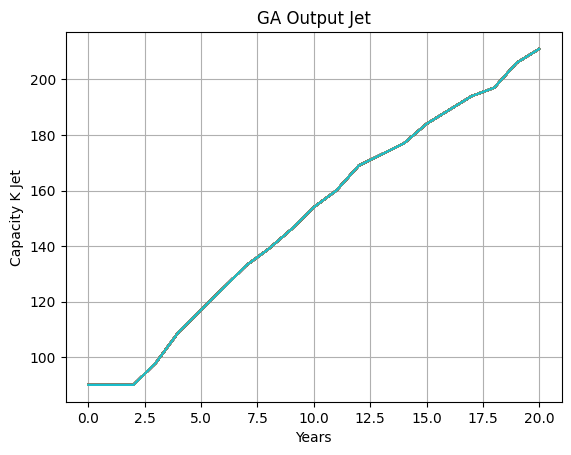

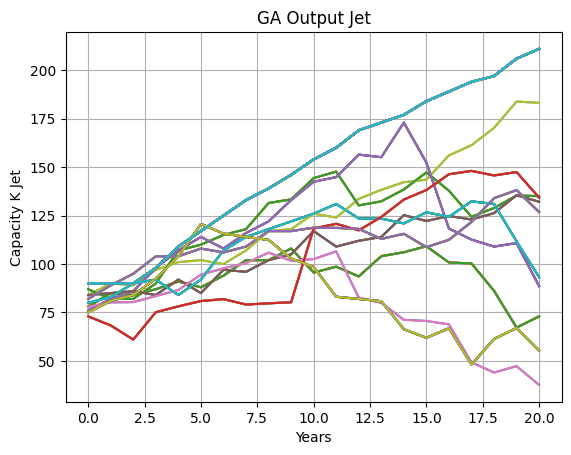

In [181]:
K_GA_Jet = fn.Capacity_2D(Param, GA_dual[0])
fn.Scenario_plot(Param, K_GA_Jet, True, "GA Output Jet", "Capacity K Jet")
fn.Scenario_plot(
    Param,
    np.vstack((K_GA_Jet, ATM_matrix[0] * (1 - S_value_matrix))),
    True,
    "GA Output Jet",
    "Capacity K Jet",
)

Visualization LH

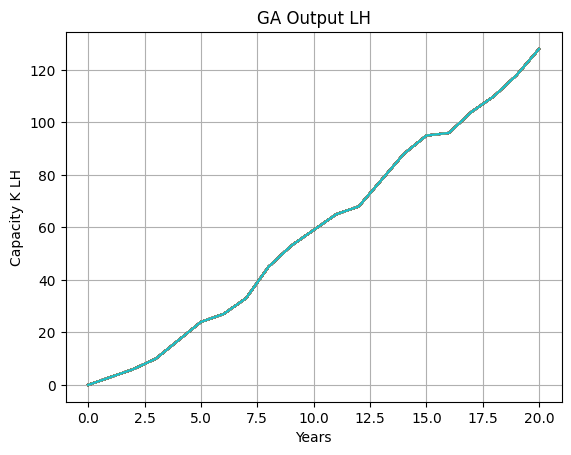

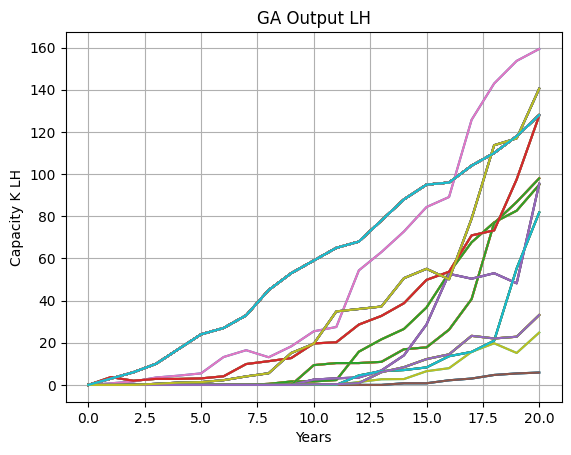

In [182]:
K_GA_LH = fn.Capacity_2D(Param, GA_dual[1], True)
fn.Scenario_plot(Param, K_GA_LH, True, "GA Output LH", "Capacity K LH")
fn.Scenario_plot(
    Param,
    np.vstack((K_GA_LH, ATM_matrix[0] * (S_value_matrix))),
    True,
    "GA Output LH",
    "Capacity K LH",
)

Total Capacity

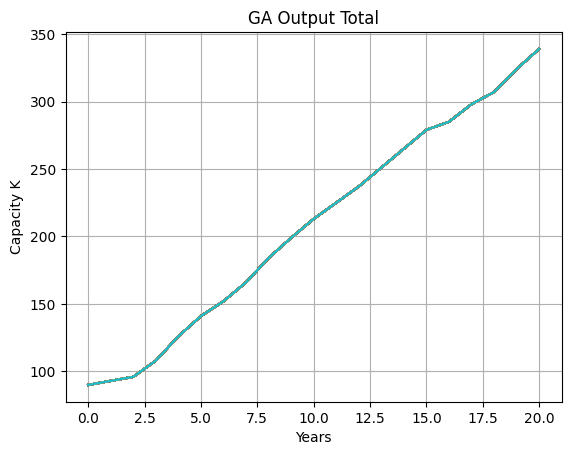

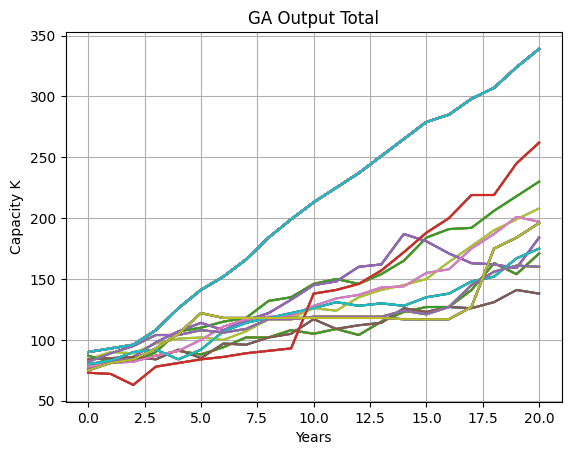

In [183]:
K_GA_total = fn.Capacity_2D(Param, delta_K_GA)

fn.Scenario_plot(Param, K_GA_total, True, "GA Output Total", "Capacity K")
fn.Scenario_plot(
    Param, np.vstack((K_GA_total, ATM_matrix[0])), True, "GA Output Total", "Capacity K"
)

# Decision Rule

Parameters for Decision Rule Optimization

In [184]:
Param["lower_theta"] = 2
Param["upper_theta"] = 20
Param["stepsize_theta"] = 1
Param["lower_condition"] = 0
Param["upper_condition"] = 20
Param["stepsize_condition"] = 0.1

In [208]:
def Evaluation(Param, K0, ATM, S_values, Pax, n=1000):
    """
    This function first calls the Optimization function to generate a list of tuples
    consisiting of each pair (defined sample size n) of theta and conditon, it then
    continues to evaluates all the tuples by iterating over each pair to find the
    maximum ENPV value

    Args:
        Param (dict): Parameter Dictionary
        D (ndarray): Demand Matrix
        n (int): Sample Size

    Returns:
        max_enpv (int): Maximum value of the ENPV,
        max_theta (int): optimal value of theta,
        max_cond (int): optimal value of the condition

    To call this function use the following syntax:
        Evaluation(Param, D, n)
    """
    # Calling the Optimization function to get the list of tuples
    optimization_params = fn.Optimization_parameters(Param, n)

    # Initialize the maximum values
    max_enpv = float("-inf")
    max_theta = None
    max_cond = None

    # ATM_Jet = ATM * (1 - S_values)
    # ATM_LH = ATM * S_values

    for theta, condition in optimization_params:
        delta_K = np.round(fn.Decision_Rule(Param, K0, ATM, theta, condition), 0)
        delta_K_Jet = np.full(delta_K.shape, Param["K0"], dtype=delta_K.dtype)
        delta_K_LH = np.full(delta_K.shape, Param["K0_LH"], dtype=delta_K.dtype)

        ENPV = fn.ENPV_calculation(
            Param, delta_K, delta_K_Jet, delta_K_LH, ATM, S_values, Pax
        )
        if ENPV > max_enpv:
            max_enpv = ENPV
            max_theta = theta
            max_cond = condition

    return max_enpv, max_theta, max_cond

In [209]:
ENPV_Decision = Evaluation(
    Param, Param["K0"], ATM_matrix[0], S_value_matrix, Shock_Scenarios, n=1000
)

print("Optomal ENPV: ", ENPV_Decision[0])
print("Optimal Theta: ", ENPV_Decision[1])
print("Optimal Condition: ", ENPV_Decision[2])

Optomal ENPV:  97507196.97107206
Optimal Theta:  17
Optimal Condition:  5.5


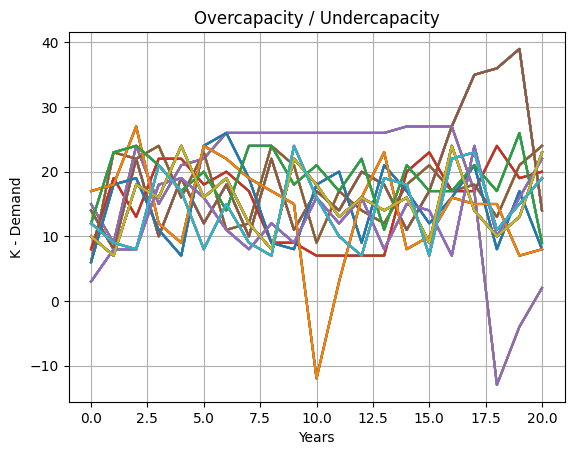

In [201]:
flex_delta_K = fn.Decision_Rule(
    Param, Param["K0"], ATM_matrix[0], ENPV_Decision[1], ENPV_Decision[2]
)


K_Flex2 = fn.Capacity_2D(Param, flex_delta_K)
diff = K_Flex2 - ATM_matrix[0]
fn.Scenario_plot(Param, diff, True, "Overcapacity / Undercapacity", "K - Demand")

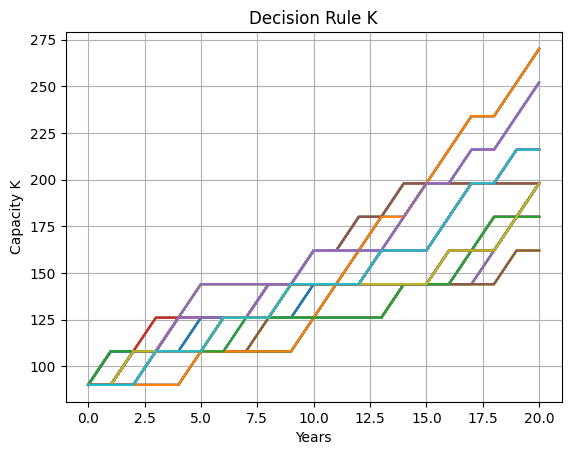

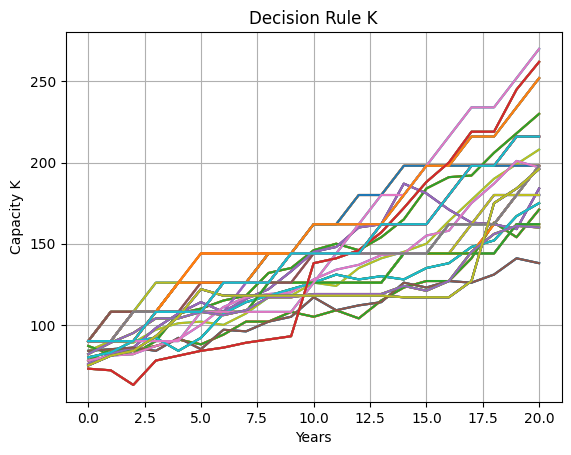

In [202]:
fn.Scenario_plot(Param, K_Flex2, True, "Decision Rule K", "Capacity K")
fn.Scenario_plot(
    Param,
    np.vstack((K_Flex2, ATM_matrix[0])),
    True,
    "Decision Rule K",
    "Capacity K",
)

In [203]:
flex_delta_K_Jet = flex_delta_K * (1 - S_value_matrix)
flex_delta_K_LH = flex_delta_K * S_value_matrix
NPV_Decision = fn.NPV_calculation(
    Param,
    flex_delta_K,
    flex_delta_K_Jet,
    flex_delta_K_LH,
    ATM_mix,
    S_value_matrix,
    Shock_Scenarios,
)

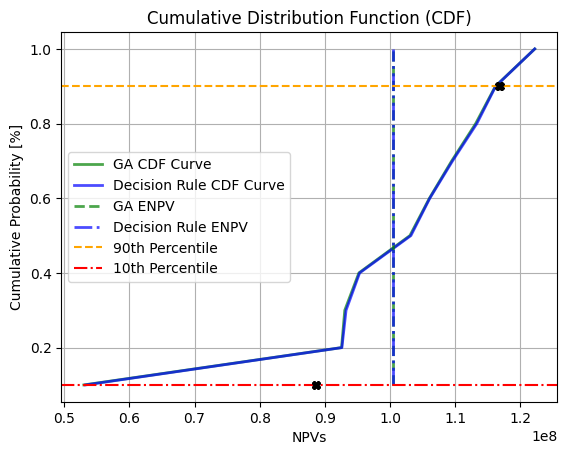

[88599319.19898058, 116756583.70249215, 88674756.38222235, 116795068.89551307]

In [204]:
fn.CDF_Plot(NPV_GA, NPV_Decision, "GA", "Decision Rule")

# Stopping the Runtime

In [191]:
end_time = time.time()

# Calculate the Total Runtime
total_run_time = end_time - start_time

# Display the Total Runtime
print("Total Runtime \t=", round(total_run_time, 2), "s")
print("Total Runtime \t=", round(total_run_time / 60, 2), "min")
print("Total Runs \t=", Param["No_Forecasts"])

Total Runtime 	= 6.89 s
Total Runtime 	= 0.11 min
Total Runs 	= 10


I adjusted the second smoothing (smoothing of Load Factor). Currently it is out commented in the Function as it safes 1/3 of the time. For "No_Forecasts": 30000 the Code takes 20 instead of 30 seconds.

## Multiprocessing

In [192]:
# import multiprocessing


# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     results = pool.map(fn.ATM, input_list)  # Map function to pool

In [193]:
# from multiprocessing import Pool

# # input_list = list of each scenario (rows of Shock_forecast)
# input_list = [row for row in Shock_Scenarios]  # shape: [No_Forecasts, Fth]
# args_list = [(Param, scenario) for scenario in input_list]

# with Pool(processes=8) as pool:
#     results = pool.starmap(fn.Load_Factor_matrix, args_list)

In [194]:
# import multiprocessing as mp


# # Helper function for multiprocessing
# def compute_load_factor(scenario):
#     return fn.Load_Factor_matrix(Param, scenario)


# if __name__ == "__main__":
#     # Number of processes (or use mp.cpu_count())
#     pool = mp.Pool(processes=4)

#     # Map each scenario to the worker pool
#     results = pool.map(compute_load_factor, Shock_Scenarios)

#     pool.close()
#     pool.join()

#     # Combine results if needed (e.g., into a matrix)
#     LF_test_matrix = np.array(results)  # Or pd.DataFrame(results), etc.

Loading Bar

In [195]:
# from tqdm.auto import tqdm

Example Usage

In [196]:
# # Generate input list with separate dictionary copies
# input_list = [Param.copy() for _ in range(Param["No_Forecasts"])]

# # Create a pool of worker processes
# with multiprocessing.Pool(processes=8) as pool:
#     # Use imap_unordered for better progress tracking with tqdm
#     results = list(
#         tqdm(
#             pool.imap_unordered(fn.ATM, input_list),
#             total=len(input_list),
#             desc="Processing Forecasts",
#         )
#     )